# Rapid Eye Movements (REMs) detection

This notebook demonstrates how to use YASA to automatically detect rapid eye movements (REMs) on EOG data.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Data loading

Let's load 50 seconds of EOG data (LOC and ROC) during REM sleep, sampled at 256 Hz.

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


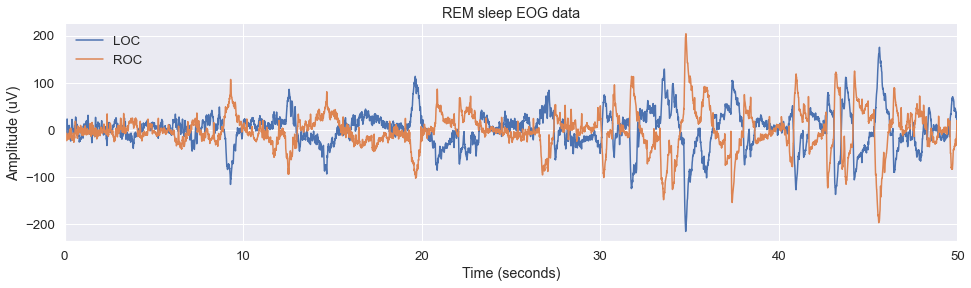

In [2]:
# Load data
file = np.load('data_EOGs_REM_256Hz.npz')
data, sf, chan = file['data'], file['sf'], file['chan']

# Keep only 50 seconds of data
loc = data[0, 77000:89801]
roc = data[1, 77000:89801]

# Define sampling frequency and time vector
times = np.arange(loc.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, loc, label='LOC', lw=1.5)
plt.plot(times, roc, label='ROC', lw=1.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('REM sleep EOG data')
plt.legend(loc='best', frameon=False)
sns.despine()

## Apply the detection

We use the [rem_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.rem_detect.html#yasa.rem_detect) function to apply the detection. The output of the detection is a [REMResults](file:///C:/Users/Raphael/Desktop/yasa/docs/build/html/generated/yasa.REMResults.html#yasa.REMResults) class, which comes with some pre-compiled functions (also called methods). For instance, the [summary](file:///C:/Users/Raphael/Desktop/yasa/docs/build/html/generated/yasa.REMResults.html#yasa.REMResults.summary) method returns a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) with all the detected REMs and their properties.

The algorithm is based on an amplitude thresholding of the negative product of the LOC and ROC filtered signal. As such, this function requires BOTH the LOC and ROC EOG data, it does NOT work with a single EOG.

In [3]:
from yasa import rem_detect

# Short version
# rem = rem_detect(loc, roc, sf)

# Long version (withh all optional, implicit, options)
rem = rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), 
                 duration=(0.3, 1.5), freq_rem=(0.5, 5), remove_outliers=False, 
                 verbose=False)

# Get the detection dataframe
events = rem.summary()
events.round(3)

,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
0,8.957,9.305,9.715,0.758,88.244,68.015,267.151,161.115,239.796,148.675
1,11.930,12.547,12.996,1.066,66.186,64.046,104.924,107.668,172.843,113.175
2,19.359,19.648,20.000,0.641,85.163,75.431,299.404,248.633,214.701,229.238
3,20.672,20.859,21.434,0.762,61.957,56.537,235.789,343.770,97.166,101.437
4,27.387,27.496,27.863,0.477,63.463,60.337,692.785,463.742,214.555,136.931
5,30.078,30.219,30.969,0.891,74.374,92.868,586.633,564.299,95.455,142.268
6,30.688,30.773,31.004,0.316,43.694,72.254,565.349,797.940,219.996,266.146
7,31.016,31.766,32.316,1.301,120.829,99.996,171.065,120.350,274.071,171.178
8,32.992,33.555,33.914,0.922,89.449,98.203,136.306,195.899,236.594,253.074
9,33.914,34.074,34.617,0.703,79.252,105.342,467.228,612.447,141.707,202.182


### Plot the detected REMs

In [4]:
# Let's get a boolean mask of the REMs in data
mask = rem.get_mask()
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

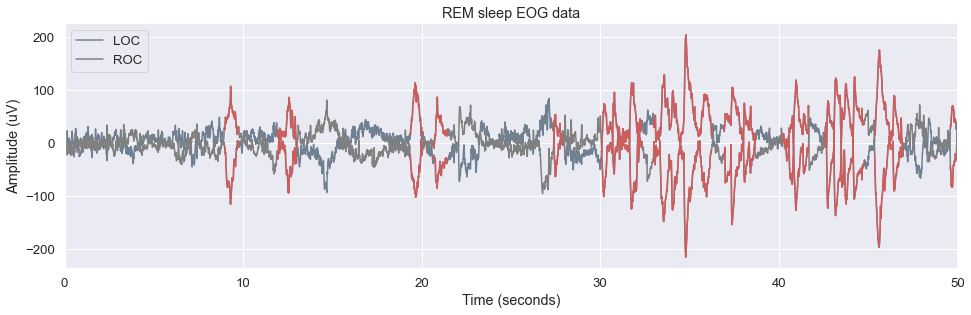

In [5]:
loc_highlight = loc * mask[0, :]
roc_highlight = roc * mask[1, :]

loc_highlight[loc_highlight == 0] = np.nan
roc_highlight[roc_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, loc, 'slategrey', label='LOC')
plt.plot(times, roc, 'grey', label='ROC')
plt.plot(times, loc_highlight, 'indianred')
plt.plot(times, roc_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('REM sleep EOG data')
plt.legend()
sns.despine()

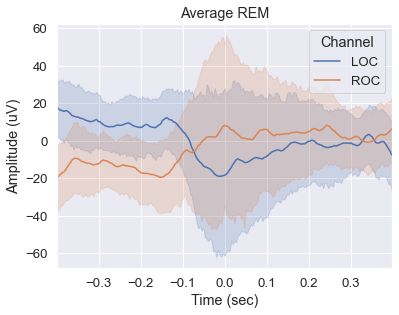

In [6]:
rem.plot_average(center="Peak", time_before=0.4, time_after=0.4);

### Restraining the detection to REM sleep

In [7]:
hypno = 4 * np.ones_like(loc)
rem = rem_detect(loc, roc, sf, hypno=hypno, include=4)
rem.summary().round(3)

,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope,Stage
0,8.957,9.305,9.715,0.758,88.244,68.015,267.151,161.115,239.796,148.675,4
1,12.359,12.547,12.996,0.637,66.186,64.046,355.125,336.453,172.843,113.175,4
2,19.359,19.648,20.000,0.641,85.163,75.431,299.404,248.633,214.701,229.238,4
3,20.672,20.859,21.434,0.762,61.957,56.537,235.789,343.770,97.166,101.437,4
4,27.387,27.496,27.863,0.477,63.463,60.337,692.785,463.742,214.555,136.931,4
5,30.078,30.219,30.688,0.609,74.374,92.868,586.633,564.299,148.232,205.972,4
6,30.688,30.773,31.004,0.316,43.694,72.254,565.349,797.940,219.996,266.146,4
7,31.637,31.766,32.316,0.680,120.829,99.996,938.778,780.516,274.071,171.178,4
8,32.992,33.555,33.914,0.922,89.449,98.203,136.306,195.899,236.594,253.074,4
9,33.914,34.074,34.617,0.703,79.252,105.342,467.228,612.447,141.707,202.182,4


In [8]:
rem.summary(grp_stage=True)

,Count,Density,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
Stage,,,,,,,,,
4,23,27.597844,0.646569,89.546864,95.963795,482.700003,490.028425,222.709253,235.459598


### Computation time

In [9]:
%timeit rem_detect(loc, roc, sf)

7.9 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
# Line profiling
# %load_ext line_profiler
# %lprun -f rem_detect rem_detect(loc, roc, sf)